(00-backprop:appendix-backpropagation-equations-for-mlps)=
# Appendix: BP equations for MLPs

Closed-form expressions for the gradients 
is generally more efficient to compute, since 
no explicit passing of gradients between nodes is performed.
Moreover, they can give us an understanding of the dynamics of gradient flow, e.g. bottlenecks.
In this section, we derive BP equations specifically for MLPs.
Recall that a dense layer with weights $\boldsymbol{\mathsf{w}}_j \in \mathbb{R}^d$ 
and bias ${b}_j \in \mathbb{R}$ computes given an input $\boldsymbol{\mathsf{x}} \in \mathbb{R}^d$
the following equations for $j = 1, \ldots, h$ where $h$ is the layer width:

```{math}
:label: fully-connected-layer
\begin{aligned}
    z_j &= \boldsymbol{\mathsf{x}} \cdot \boldsymbol{\mathsf{w}}_j + {b}_j \\
    y_j &= \phi\left( z_j \right) \\
\end{aligned}
```

Given global gradients 
$\partial \ell / \partial y_j$
that flow into the layer via the output nodes, we compute the global gradients of nodes 
$\boldsymbol{\mathsf{z}}$, $\boldsymbol{\mathsf{w}}$, $\boldsymbol{\mathsf{b}}$, and $\boldsymbol{\mathsf{x}}$
in the layer. 
As previously discussed, this can be done by tracking backward dependencies in 
the computational graph ({numref}`jacobian`). Following backward dependencies for the compute nodes:

```{math}
\begin{align}
\frac{\partial \ell}{\partial {z}_j} &= \sum_k \frac{\partial \ell}{\partial {y}_k}  \frac{\partial {y}_k}{\partial {z}_j} =  \sum_k \frac{\partial \ell}{\partial {y}_k} \mathsf{J}^{\phi}_{kj} \\
\frac{\partial \ell}{\partial {x}_i} &= \sum_j \frac{\partial \ell}{\partial {z}_j} \frac{\partial {z}_j}{\partial {x}_i} = \sum_j \frac{\partial \ell}{\partial {z}_j} {w}_{ij} = \sum_j \frac{\partial \ell}{\partial {z}_j} {w}_{ji}^{\top}
\end{align}
```

where
$\mathsf{J}^{\phi}_{kj}(\boldsymbol{\mathsf{z}}) = ({\partial y_k}/{\partial z_j}) |_{\boldsymbol{\mathsf{z}}}$
is the [Jacobian](https://mathworld.wolfram.com/Jacobian.html). The second equation is visualized below:

```{figure} ../../../img/jacobian.svg
---
name: jacobian
width: 75%
align: center
---
Node dependencies in compute nodes of a fully connected layer. All nodes $\boldsymbol{\mathsf{z}}_k$ depend on $\boldsymbol{\mathsf{x}}_j.$
```

The gradients are passed towards the input nodes, so that the second equation uses the gradients calculated using the first equation. 
For typical activations, such as $\text{ReLU}$ or $\text{Tanh}$, the Jacobian has no cross-dependencies and it reduces to the diagonal matrix $\phi^\prime(z_k)$. 
Hence, the output node grads are modulated by the derivative of the activation function, e.g. if $\phi^\prime \approx 0,$ then the gradients also vanish. 

Finally, we compute gradients of the weights:

```{math}
\begin{align}
\frac{\partial \ell}{\partial{w}_{ij}} 
&= \frac{\partial \ell}{\partial{z}_{j}} \frac{\partial{z}_{j}}{\partial{w}_{ij}} 
= {x}_{i} \frac{\partial \ell}{\partial{z}_{j}} \label{eq:gradient_weight} \\
\frac{\partial \ell}{\partial{b}_{j}} 
&= \frac{\partial \ell}{\partial{z}_{j}}  \frac{\partial{z}_{j}} {\partial{b}_{j}} 
= \frac{\partial \ell}{\partial{z}_{j}}. \label{eq:gradient_bias} \\
\end{align}
```

<br>

**Remark.** The weight gradient exhibits sensitivity to the input scale, introducing an implicit scaling factor to the LR that varies with input dim. This motivates the use of normalization layers, or some weight initialization scheme that ensures inputs to a hidden layer are consistently scaled.

<br>

## Batch computation

Processing a batch of size $\mathcal{B}$ in parallel, in principle, creates a graph 
consisting of $B = |\mathcal{B}|$ copies of the original computational graph that share the same parameters. 
The outputs of these form the loss node $\mathcal{L} = \frac{1}{B}\sum_{b \in \mathcal{B}} \ell_b.$ For simplicity, let's assume that $\boldsymbol{\mathsf{J}}^\phi = \text{diag}(\phi^\prime(\boldsymbol{\mathsf{z}}))$ which is true for usual activations. The output and input gradients can be written in the following matrix notation for fast computation:

```{math}
:label: backprop-output
\begin{aligned}
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}}_{(B, h)}
&= 
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}} \odot \phi^\prime(\boldsymbol{\mathsf{Z}})}_{(B, h)\, \cdot\, (B, h)}
\end{aligned}
```

```{math}
:label: backprop-input
\begin{aligned}
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{X}}}}_{(B, d)} &= \underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}\, \boldsymbol{\mathsf{W}}^\top}_{(B, h) \times (h, d)} \hspace{18pt}
\end{aligned}
```

The stacked output tensors $\boldsymbol{\mathsf{Z}}$ and $\boldsymbol{\mathsf{Y}}$ have shape $(B, h)$ where $h$ is the layer width and $B$ is the batch size, while the stacked input tensor $\boldsymbol{\mathsf{X}}$ has shape $(B, d)$ where $d$ is the input dimension. Finally, the weight tensor $\boldsymbol{\mathsf{W}}$ has shape $(d, h).$ For the weights, the contribution of the entire batch has to be accumulated ({numref}`weight-backprop.drawio`):

```{math}
:label: backprop-weights
\begin{align}
\underbrace{\frac{\partial \mathcal{L}}{\partial{\boldsymbol{\mathsf{W}}}}}_{(d, h)}
= 
\underbrace{\boldsymbol{\mathsf{X}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}}_{(d, B) \times (B, h)}. \hspace{30pt}
\end{align}
```

```{math}
:label: backprop-bias
\begin{align}
\underbrace{\frac{\partial \mathcal{L}}{\partial{\boldsymbol{\mathsf{b}}}}}_{(1, h)}
= 
\underbrace{[1, \ldots, 1] \, \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}}_{(1, B) \times (B, h)}.
\end{align}
```

**Remark.** One way to remember these equations is that the shapes must check out.

<br>

```{figure} ../../../img/weight-backprop.drawio.svg
---
name: weight-backprop.drawio
width: 30%
align: center
---
Node dependencies for a weight node. The nodes $\boldsymbol{\mathsf{z}}_{bj}$ depend on $\boldsymbol{\mathsf{w}}_{ij}$ for $b = 1, \ldots, B.$
```

## Cross entropy

In this section, we compute the gradient across the **cross-entropy loss**.
This can be calculated using backpropagation, but we will derive it 
symbolically to get a closed-form formula. Recall that cross-entropy loss computes
for logits $\boldsymbol{\mathsf{s}}$:

$$
\begin{aligned}
\ell 
&= -\log \frac{\exp({s_{y}})}{\sum_{k=1}^m \exp({{s}_{k}})} \\
&= - s_{y} + \log \sum_{k=1}^m \exp({s_k}).
\end{aligned}
$$

Calculating the derivatives, we get

$$
\begin{aligned}
\frac{\partial \ell}{\partial s_j} 
&= - \delta_{j}^y + \frac{\exp({s_j})}{\sum_{k=1}^m \exp({s_k})} \\ \\
&= - \delta_{j}^y + \text{softmax}(s_j) = 
\left\{
\begin{array}{l}
p_j \quad \quad\;\;\; \text{if $\;j \neq y$}\\
p_y - 1 \quad \text{else}\\
\end{array}
\right.
\end{aligned}
$$

where $\delta_{j}^y$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).
This makes sense: having output values in nodes that do not correspond 
to the true class only contributes to increasing the loss. This effect is particularly strong 
when the model is confidently wrong such that $p_y \approx 0$ on the true class and
$p_{j^*} \approx 1$ where $j^* = \text{arg max}_j\, s_j$
is the predicted wrong class.
On the other hand,
increasing values in the node for the true class results in decreasing loss for all nodes.
In this case, 
$\text{softmax}(\boldsymbol{\mathsf{s}}) \approx \mathbf{1}_y,$ and
${\partial \ell}/{\partial \boldsymbol{\mathsf{s}}}$ becomes close to the zero vector, 
so that $\nabla_{\boldsymbol{\Theta}} \ell$ is also close to zero.

The gradient of the logits ${\boldsymbol{\mathsf{S}}}$ can be written in matrix form
where $\mathcal{L} = \frac{1}{B}\sum_b \ell_b$:

```{math}
:label: backprop-cross-entropy
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial {\boldsymbol{\mathsf{S}}}} 
&= - \frac{1}{B} \left( \boldsymbol{\delta} - \text{softmax}({\boldsymbol{\mathsf{S}}}) \right).
\end{aligned}
```

**Remark.** Examples with similar features but different labels can contribute to a smoothing between 
the labels of the predicted probability vector. This is nice since we can use the probability
value as a measure of confidence. We should also expect a noisy loss curve in the presence of significant label noise.

## Gradient checking

Computing the cross-entropy for a batch:

In [1]:
import torch
import torch.nn.functional as F

B = 32
N = 27

# forward pass
t = torch.randint(low=0, high=N, size=(B,))
x = torch.randn(B, 128, requires_grad=True)
w = torch.randn(128, N, requires_grad=True)
b = torch.randn(N,      requires_grad=True)
z = x @ w + b
y = torch.tanh(z)

for node in [x, w, b, z, y]:
    node.retain_grad()

# backprop batch loss
loss = -torch.log(F.softmax(y, dim=1)[range(B), t]).sum() / B
loss.backward()

Plotting the gradient of the logits:

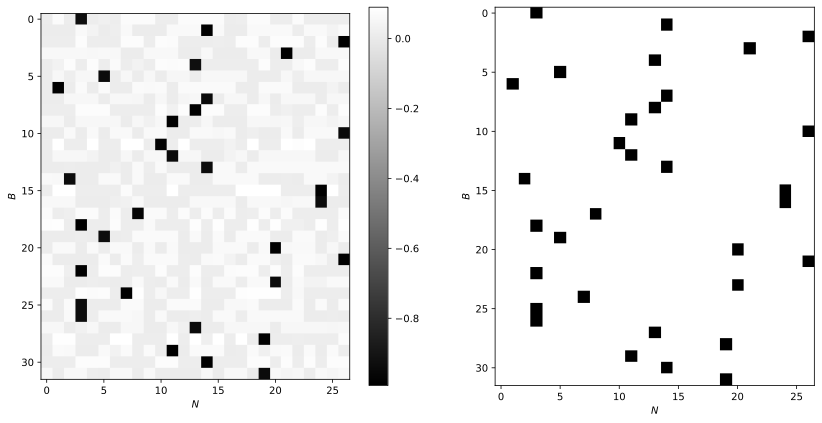

In [2]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
c = ax[0].imshow(y.grad.detach().numpy() * B, cmap='gray')
ax[1].imshow(-F.one_hot(t, num_classes=N).detach().numpy(), cmap='gray')
ax[0].set_ylabel("$B$")
ax[1].set_ylabel("$B$")
ax[0].set_xlabel("$N$")
ax[1].set_xlabel("$N$")
plt.colorbar(c, ax=ax[0])
fig.tight_layout();

Fig. *Gradient of the logits for given batch (**left**) and actual targets (**right**). Notice the sharp contribution to decreasing loss by increasing the logit of the correct class. Other nodes contribute to increasing the loss. It's hard to see, but incorrect pixels have positive values that sum to the pixel value in the target.*

Checking this to ensure correctness:

In [3]:
y.grad.sum(dim=1, keepdim=True).abs().mean()

tensor(1.8026e-09)

Recall that the above equations were vectorized with the convention that the gradient with respect to a tensor $\boldsymbol{\mathsf{v}}$ has the same shape as $\boldsymbol{\mathsf{v}}.$ In PyTorch, `v.grad` is the global gradient with respect to `v` of the tensor that called `.backward()` (i.e. `loss` in our case). The following computation should give us an intuition of how gradients flow backwards through the neural net starting from the loss to all intermediate results:

In [4]:
J = 1 - y ** 2
δ_tk = F.one_hot(t, num_classes=N)
dy = - (1 / B) * (δ_tk - F.softmax(y, dim=1))
dz = dy * J
dx = dz @ w.T
dw = x.T @ dz
db = dz.sum(0, keepdim=True)

Refer to {eq}`backprop-cross-entropy`, {eq}`backprop-output`, {eq}`backprop-input`, {eq}`backprop-weights`, and {eq}`backprop-bias` above. These equations can be checked using `autograd` as follows:

In [5]:
def compare(name, dt, t):
    exact  = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad, rtol=1e-5)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{name:<3s} | exact: {str(exact):5s} | approx: {str(approx):5s} | maxdiff: {maxdiff:.2e}')


compare('y', dy, y)
compare('z', dz, z)
compare('x', dx, x)
compare('w', dw, w)
compare('b', db, b)

y   | exact: False | approx: True  | maxdiff: 1.86e-09
z   | exact: False | approx: True  | maxdiff: 9.31e-10
x   | exact: False | approx: True  | maxdiff: 1.86e-09
w   | exact: False | approx: True  | maxdiff: 3.73e-09
b   | exact: False | approx: True  | maxdiff: 9.31e-10
